<a href="https://colab.research.google.com/github/Loptt/forest-fire-detector/blob/main/classifier_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Classifier with autoencoders

## Data Loading

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras import Input
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

train_dir = "/content/gdrive/My Drive/Escuela/Octavo Semestre/Fire_Original/Training"
test_dir = "/content/gdrive/My Drive/Escuela/Octavo Semestre/Fire_Original/Test"

#train_dir = "data/Training"
#test_dir = "data/Test"

Mounted at /content/gdrive


In [3]:
datagen = ImageDataGenerator(rescale=1./255,
                              zoom_range=0.2,
                              horizontal_flip=True)

## Autoencoder creation

In [4]:
train_generator_autoencoder = datagen.flow_from_directory(train_dir,
                                                target_size=(254, 254), 
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='input')

test_generator_autoencoder = datagen.flow_from_directory(test_dir,
                                                target_size=(254, 254),
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='input')

Found 14367 images belonging to 2 classes.


KeyboardInterrupt: ignored

Encoder

In [20]:
input_img = Input(shape=(254, 254, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

Decoder

In [21]:
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (2, 2), activation='relu', padding='valid')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

Compile Model

In [22]:
autoencoder = Model(input_img, decoded)

optimizer = optimizers.Adam(lr=0.5)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

plot_model(autoencoder, show_shapes=True, show_layer_names=True)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 254, 254, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 16)      4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 16)        0   

In [23]:
checkpoint_filepath = "/content/gdrive/My Drive/Escuela/Octavo Semestre/DSDM/autoencoder/autoencoder"
#checkpoint_filepath = "checkpoints/autoencoder"

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)


In [25]:
try:
    autoencoder.load_weights(checkpoint_filepath)
    print("Previous weights loaded")
except:
    print("No weights found")

Previous weights loaded


In [1]:
history = autoencoder.fit(train_generator_autoencoder,
                epochs=50,
                batch_size=100,
                shuffle=True,
                validation_data=test_generator_autoencoder,
                callbacks=[model_checkpoint_callback])

NameError: ignored

In [12]:
encoder_filepath = "/content/gdrive/My Drive/Escuela/Octavo Semestre/DSDM/models/encoder.h5"
#encoder_filepath = "models/encoder.h5"

encoder = Model(input_img, encoded, name="encoder")
encoder.save(encoder_filepath)

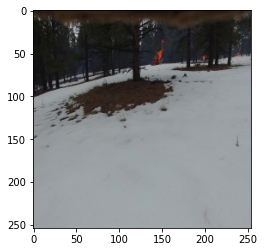

In [13]:
from skimage import io
import numpy as np

img_path = "/content/gdrive/My Drive/Escuela/Octavo Semestre/Fire_Original/Test/Fire/resized_test_fire_frame50.jpg"
#img_path = "data/Test/Fire/resized_test_fire_frame50.jpg"

img = io.imread(img_path)
plt.imshow(img)
plt.show()

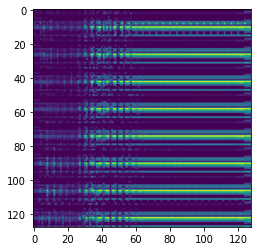

In [14]:
imgs = np.array([img])
output = encoder.predict(imgs)
plt.imshow(output[0].reshape(32 * 4, 32 * 4).T)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


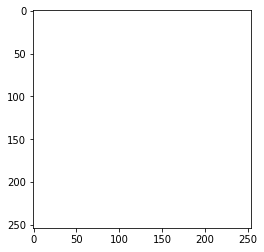

In [17]:
imgs = np.array([img])
output = autoencoder.predict(imgs)
output = output * 255
plt.imshow(output[0])
plt.show()

## Classifier

In [ ]:
train_generator = datagen.flow_from_directory(train_dir,
                                                target_size=(254, 254), 
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='binary')

test_generator = datagen.flow_from_directory(test_dir,
                                                target_size=(254, 254),
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='binary')

Found 39395 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [ ]:
encoder = load_model("models/encoder.h5")
encoder.trainable = False
encoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 254, 254, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 127, 127, 16)      4624      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 16)        0   

In [ ]:
input_latent = Input(shape=(32, 32, 16))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_latent)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

classifier_part = Model(input_latent, output_layer, name="classifier_part")
classifier_part.summary()

Model: "classifier_part"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 32, 32, 16)]      0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 8, 8, 32)          9248      
_________________________________________________________________
flatten_22 (Flatten)         (None, 2048)          

In [ ]:
classifier_input = Input(shape=(254, 254, 3), name="img")
encoded_img = encoder(classifier_input)
classifier_output = classifier_part(encoded_img)

classifier = Model(classifier_input, classifier_output, name="classifier")
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 254, 254, 3)]     0         
_________________________________________________________________
encoder (Functional)         (None, 32, 32, 16)        7840      
_________________________________________________________________
classifier_part (Functional) (None, 1)                 4221537   
Total params: 4,229,377
Trainable params: 4,221,537
Non-trainable params: 7,840
_________________________________________________________________


In [ ]:
optimizer = optimizers.Adam(lr=0.01)
classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath = "/content/gdrive/My Drive/Escuela/Octavo Semestre/DSDM/classifier/classifier"
#checkpoint_classif_filepath = "checkpoints/classifier/classifier"

model_classif_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_classif_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='auto',
    save_best_only=True)

In [ ]:
history = classifier.fit(train_generator,
                epochs=10,
                batch_size=100,
                shuffle=True,
                validation_data=test_generator,
                callbacks=[model_classif_checkpoint_callback])

Epoch 1/10
  33/1970 [..............................] - ETA: 12:27 - loss: 0.0232 - accuracy: 0.9939

KeyboardInterrupt: 